# Emoji Prediction

In [1]:
import emoji

In [2]:
# emoji.EMOJI_UNICODE

## Using Emojis That we need

In [3]:
# emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
#                     "1": ":baseball:",
#                     "2": ":grinning_face_with_big_eyes:",
#                     "3": ":disappointed_face:",
#                     "4": ":fork_and_knife:",
#                     "5": ":hundred_points:",
#                     "6": ":fire:",
#                     "7": ":face_blowing_a_kiss:",
#                     "8": ":chestnut:",
#                     "9":":flexed_biceps:"}
emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":beaming_face_with_smiling_eyes:",
                    "3": ":downcast_face_with_sweat:",
                    "4": ":fork_and_knife:",
                   }


In [4]:
emoji.emojize(':fire:')

'🔥'

In [5]:
for e in emoji_dictionary.values():
    print(emoji.emojize(e))

❤️
⚾
😁
😓
🍴


## Process Custom Dataset

In [6]:
import pandas as pd
import numpy as np

In [7]:
train=pd.read_csv('train_emoji.csv',header=None)
test=pd.read_csv('test_emoji.csv',header=None)
train.head()

,0,1,2,3
0,never talk to me again,3,NaN,NaN
1,I am proud of your achievements,2,NaN,NaN
2,It is the worst day in my life,3,NaN,NaN
3,Miss you so much,0,NaN,[0]
4,food is life,4,NaN,NaN


In [8]:
# Print the sentebces with emojis
data=train.values
print(data.shape)

(132, 4)


In [9]:
X_train=train[0]
y_train=train[1]

X_test=test[0]
y_test=test[1]

In [10]:
for i in range(5):
    print(X_train[i],emoji.emojize(emoji_dictionary[str(y_train[i])]))

never talk to me again 😓
I am proud of your achievements 😁
It is the worst day in my life 😓
Miss you so much ❤️
food is life 🍴


## Converting Sentences into Embeddings

In [11]:
f=open('glove.6B.50d.txt',encoding='utf8')


In [12]:
embeddings_index={}

for line in f:
    values=line.split()
    word=values[0]
    coeff=np.asarray(values[1:],dtype='float')
    embeddings_index[word]=coeff
f.close()
  


In [13]:
emb_dim=embeddings_index['eat'].shape[0]
print(emb_dim)

50


## Converting sentences into vectors (Embedding Layer Output)

In [14]:
def embedding_output(X):
    max_len = 10
    embedding_out = np.zeros((X.shape[0], max_len, emb_dim))
    for ix in range(X.shape[0]):
        X[ix] = X[ix].split()
        for ij in range(len(X[ix])):
            # Go to every word in the current(ix) sentence
            try:
                embedding_out[ix][ij] = embeddings_index[X[ix][ij].lower()]
            except:
                embedding_out[ix][ij] = np.zeros((50,))
    return embedding_out

embeddings_matrix_train=embedding_output(X_train)
embeddings_matrix_test=embedding_output(X_test)


<ipython-input-14-6c21e55cac3b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ix] = X[ix].split()


In [15]:
print(X_train[0])
print(len(X_train[0]))

['never', 'talk', 'to', 'me', 'again']
5


In [16]:
print(embeddings_matrix_train.shape) # 132 sentences, maximum word in one sentence 10, each word dim 50 
print(embeddings_matrix_test.shape)  # 56 sentences, maximum word in one sentence 10, each word dim 50 


(132, 10, 50)
(56, 10, 50)


### One Hot vector

In [17]:
from tensorflow.keras.utils import to_categorical
print(y_train.shape,y_test.shape)
y_train=to_categorical(y_train,num_classes=5)
y_test=to_categorical(y_test,num_classes=5)
print(y_train.shape,y_test.shape)

(132,) (56,)
(132, 5) (56, 5)


## RNN/LSTM Model

In [18]:
from keras.layers import *
from keras.models import Sequential

In [39]:
model=Sequential()
model.add(LSTM(64,input_shape=(10,50)))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0         
Total params: 29,765
Trainable params: 29,765
Non-trainable params: 0
_________________________________________________________________


In [40]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
checkpoint=ModelCheckpoint('best_model.h5',monitor='val_loss',verbose=True,save_best_only=True)
early_stop=EarlyStopping(patience=25,monitor='val_loss')

hist=model.fit(embeddings_matrix_train,y_train,epochs=100,batch_size=64,shuffle=True,validation_split=0.2,callbacks=[early_stop,checkpoint])

Epoch 1/100
2/2 [==============================] - 4s 737ms/step - loss: 1.6357 - accuracy: 0.1524 - val_loss: 1.5869 - val_accuracy: 0.2593

Epoch 00001: val_loss improved from inf to 1.58694, saving model to best_model.h5
Epoch 2/100
2/2 [==============================] - 0s 71ms/step - loss: 1.5853 - accuracy: 0.2667 - val_loss: 1.5858 - val_accuracy: 0.2222

Epoch 00002: val_loss improved from 1.58694 to 1.58580, saving model to best_model.h5
Epoch 3/100
2/2 [==============================] - 0s 63ms/step - loss: 1.5656 - accuracy: 0.2952 - val_loss: 1.5884 - val_accuracy: 0.2222

Epoch 00003: val_loss did not improve from 1.58580
Epoch 4/100
2/2 [==============================] - 0s 54ms/step - loss: 1.5440 - accuracy: 0.3143 - val_loss: 1.5932 - val_accuracy: 0.2222

Epoch 00004: val_loss did not improve from 1.58580
Epoch 5/100
2/2 [==============================] - 0s 59ms/step - loss: 1.5280 - accuracy: 0.3429 - val_loss: 1.6008 - val_accuracy: 0.2222

Epoch 00005: val_loss di

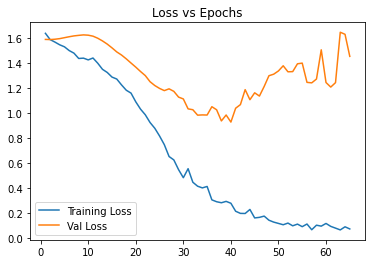

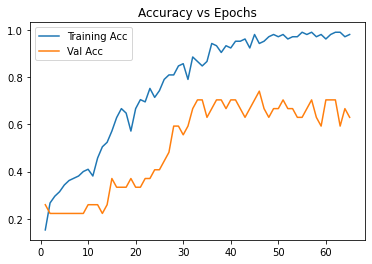

In [41]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1,len(loss)+1)

plt.title("Loss vs Epochs")
plt.plot(epochs,loss,label="Training Loss")
plt.plot(epochs,val_loss,label="Val Loss")
plt.legend()
plt.show()



plt.title("Accuracy vs Epochs")
plt.plot(epochs,acc,label="Training Acc")
plt.plot(epochs,val_acc,label="Val Acc")
plt.legend()
plt.show()

In [42]:

pred=model.predict(embeddings_matrix_test) 
classes=np.argmax(pred,axis=1)
print(classes)

[4 3 2 0 2 2 3 2 2 2 1 2 0 3 1 3 2 2 3 4 0 0 4 2 3 3 2 0 0 2 0 1 0 2 0 1 2
 3 4 2 1 0 0 1 2 0 2 2 3 3 3 0 3 2 3 2]


In [43]:
model.load_weights('best_model.h5')

In [44]:
model.evaluate(embeddings_matrix_test,y_test)

2/2 [==============================] - 0s 12ms/step - loss: 1.1659 - accuracy: 0.6607


[1.16585373878479, 0.6607142686843872]